Universidade Federal do Rio de Janeiro<br />
Instituto Alberto Luiz Coimbra de Pós-Graduação e Pesquisa<br />
Programa de Engenharia Elétrica<br />
Signals, Multimedia, and Telecommunications group<br />
(SMT / PEE / COPPE / UFRJ)

Author: Pedro Angelo Medeiros Fonini &lt;pedro.fonini@smt.ufrj.br&gt;<br />
Advisors:
* Paulo Sergio Ramirez Diniz
* Markus Vinícius Santos Lima

\\[
\newcommand{\Cbf}{\mathbf{C}}
\newcommand{\Dbf}{\mathbf{D}}
\newcommand{\Kbf}{\mathbf{K}}
\newcommand{\Ubf}{\mathbf{U}}
\newcommand{\pbf}{\mathbf{p}}
\newcommand{\sbf}{\mathbf{s}}
\newcommand{\ubf}{\mathbf{u}}
\newcommand{\vbf}{\mathbf{v}}
\newcommand{\xbf}{\mathbf{x}}
\newcommand{\ybf}{\mathbf{y}}
\newcommand{\Fcal}{\mathcal{F}}
\newcommand{\Scal}{\mathcal{S}}
\newcommand{\Pibf}{\boldsymbol{\Pi}}
\newcommand{\Psibf}{\boldsymbol{\Psi}}
\newcommand{\psibf}{\boldsymbol{\psi}}
\newcommand{\bkn}{\left[n\right]}
\newcommand{\brak}[1]{\left[ #1 \right]}
\newcommand{\prt}[1]{\left( #1 \right)}
\newcommand{\expval}[1]{ \mathsf{E} \! \left[ #1 \right] }
\DeclareMathOperator{\tr}{tr}
\\]

References:

\[1\]: P. Di Lorenzo, P. Banelli, E. Isufi, S. Barbarossa, and G. Leus, "Adaptive graph signal processing: algorithms and optimal sampling strategies," *IEEE Transactions on Signal Processing*, vol. 66, no. 13, pp. 3584–3598, 2018.

\[2\]: P. Di Lorenzo, S. Barbarossa, P. Banelli, and S. Sardellitti, "Adaptive least mean squares estimation of graph signals," *IEEE Trans. on Signal and Inf. Proc. over Networks*, vol. 2, no. 4, pp. 555–568, 2016.

In [2]:
%matplotlib inline

import sys
import os
import pathlib
import itertools
import time

import numpy as np
from scipy import linalg
import matplotlib as mpl
dfs = 14 # default font size
mpl.rc('font', family='serif', size=dfs)
mpl.rc('text', usetex=True)
import matplotlib.pyplot as plt
import pandas as pd

import cvxpy as cvx

import tqdm
tqdm.tqdm.monitor_interval = 0

sys.path.append(os.fspath(pathlib.Path().resolve().parent / 'src'))
import graphdsp as gsp

def gplot(x, *,
          cmap=mpl.cm.get_cmap('viridis'), title=None, 
          colorbar=True, edge_grayscale=False,
          show_indexes=False, filename=None, dpi=300):
    points = x.graph.nodes
    W = x.graph.W
    N = len(x)
    fig, ax = plt.subplots(frameon=False)
    ax.axis('off')
    for i in range(N):
        for j in range(i+1,N):
            if W[i,j] > 0:
                if edge_grayscale:
                    edge_color = "{}".format(1-W[i,j]/W.max())
                else:
                    edge_color = "k"
                ax.plot(points[[i,j],0], points[[i,j],1], 
                        color=edge_color, zorder=1)
    #r = x.max() - x.min()
    #if r == 0:
    #    r = 1
    #u = (x - x.min()) / r
    scatter = ax.scatter(points[:,0], points[:,1], 
                         s=100, lw=1, edgecolor='k', c=x.values, 
                         cmap=cmap, zorder=2)
    if show_indexes:
        for i in range(N):
            ax.text(points[i,0]+.015, points[i,1]+.015, str(i))
    if colorbar:
        cbar = fig.colorbar(scatter)
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title, fontsize=dfs)
    ax.set_xticks([])
    ax.set_yticks([])
    if filename:
        fig.savefig(filename, dpi=dpi)

In [3]:
np.random.seed(seed=0)

<Figure size 432x288 with 0 Axes>

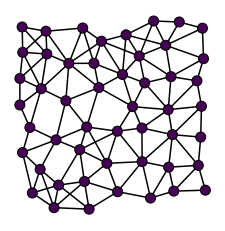

In [4]:
graph = gsp.GeometricUWG.make_random_pretty()
lambd, U = graph.spectral_decomposition()
graph.visualize_laplacian()
plt.savefig('laplacian.png')
plt.savefig('laplacian.eps')
gplot(gsp.GraphSignal([0]*len(graph), graph=graph), colorbar=False)
plt.savefig('graph.png')
plt.savefig('graph.eps')

# LMS


Signal $\xbf^o$, to be estimated, has frequency support $\Fcal$, and (compressed) frequency representation $\sbf^o$:
\\[\xbf^o = \Ubf_\Fcal \sbf^o\\]

Signal $\xbf^o$ is observed through noisy measurements at the graph nodes given by $\Scal\bkn$:
\\[\ybf\bkn = \Dbf_{\Scal\bkn}\prt{\xbf^o + \vbf\bkn}\\]

The **LMS** algorithm estimates $\xbf^o$ using the iteration:
\\[\widehat\xbf\brak{n+1} = \widehat\xbf\bkn
                          + \mu\Ubf_\Fcal\Ubf_\Fcal^*\Dbf_{\Scal\bkn}
                            \prt{\ybf\bkn - \widehat\xbf\bkn}\\]

## MaxDet

Algorithm for choosing $M$ points for sampling.

In [5]:
def maxdet(UF, batchsz=1, num=None, granular='dontcare'):
    """Implements an expanded MaxDet algorithm from [2].
    
    UF: This is the NxB matrix obtained by selecting B columns amongst the N columns
        of the NxN matrix U. In this context, U is the orthonormal matrix of eigenvectors
        of the laplacian L. `N' is the number of graph nodes, and `B' is the expected
        bandwidth of the graph signals.
    batchsz: The original MatDet algorithm presented in [2] operates by selecting, at each
        iteration, the best of the remaining nodes. This algorithm expands on that idea.
        If `batchsz==2', for example, this algorithm selects on each iteration the best
        pair of remaining nodes. If `batchsz==3', it selects the best triple of nodes on
        each iteration, and so on.
    num: If `num' is not given, this function returns a list of all nodes, in decreasing
        order of importance. If an application needs to sample from the 10 most important
        nodes from a 50-node graph, it can, e.g., select the 10 first elements from that
        50-element list. This is not efficient, however, since this function would have
        wasted time ordering the rest of the 40 elements. With that in mind, it suffices
        to provide `num=10' in order to have this function return only the list of the
        10 most important nodes (still in decreasing order of importance). If `num' is
        the same as `N', this is the same as not providing `num' at all.
    granular: When `batchsz' is greater than one, at each iteration we must decide the best
        pair of nodes, and also the order in which those two nodes will be placed in the
        list. There are two possibilities:
        'greedy': apply the original greedy algorithm from [2] restricted to the current
            batch.
        'dontcare': use any order.
    """
    N = len(UF)
    if num is None:
        num = N
    S = []
    ldets = []
    
    def get_ldet(idx):
        UF_idx = UF[idx,:]
        ews, _ = np.linalg.eigh(UF_idx.T @ UF_idx)
        ews = np.sort(ews)
        return np.sum(np.log(ews[-len(idx):]))
    
    def get_batch(*, sel, fro):
        # Select the best `sel' nodes from the list `fro' of available nodes
        if len(fro) < sel:
            raise IndexError("Can't select {} elements from {}".format(sel, fro))
        maxldet = -float('inf')
        argmax = None
        for idx in itertools.combinations(fro, sel):
            logdet = get_ldet(S + list(idx))
            if logdet > maxldet:
                argmax = idx
                maxldet = logdet
        return argmax, maxldet
    
    #print('batch size: {}'.format(batchsz))
    while True:
        #print('\n======== STARTING ITERATION ====')
        curr_batchsz = min(batchsz, num - len(S))
        #print('current batch size: {}'.format(curr_batchsz))
        #print('current S: {!r}'.format(S))
        if curr_batchsz == 0:
            return S, ldets
        batch, maxldet = get_batch(sel=curr_batchsz, fro=set(range(N)) - set(S))
        #print('calculated batch: {!r}'.format(batch))
        #print('calculated maxldet: {}'.format(maxldet))
        if granular == 'dontcare':
            S += batch
            ldets += [maxldet]*curr_batchsz
        elif granular == 'greedy':
            batch = set(batch)
            while batch:
                #print('= Starting intra-batch iteration')
                #print('    batch is {!r}'.format(batch))
                idx, ld = get_batch(sel=1, fro=batch)
                #print('    selected: {}'.format(idx))
                #print('    with ld: {}'.format(ld))
                batch.remove(idx[0])
                S.append(idx[0])
                ldets.append(ld)
            assert abs(ldets[-1] - maxldet) < 1e-13, "Oooops {} - {} = {}".format(
                ldets[-1], maxldet, ldets[-1] - maxldet)
        else:
            raise NotImplementedError('Granular policy {!r} is not implemented.'.format(granular))

$N=\mbox{graph size}$

$M=N/5$

$\Fcal=\mbox{first $M$ frequencies}$

In [6]:
N = len(graph)
M = N//5
F = list(range(M))

UF = U[:,F]

$\Ubf_\Fcal=\mbox{columns of $\Ubf$ given by $\Fcal$}$

`S` = list of graph nodes for sampling $\Fcal$-bandlimited signals, most important to least important.

In [7]:
batch_szs = [1, 2, 3]
S = []
ldets = []
print('Times (s):')
for batchsz in batch_szs:
    start_time = time.time()
    tup = maxdet(UF, batchsz=batchsz, granular='greedy')
    end_time = time.time()
    S.append(tup[0])
    ldets.append(tup[1])
    print('{:6.2f}'.format(end_time - start_time))

Times (s):
  0.21
  1.45
 10.32


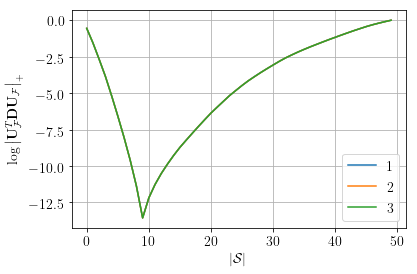

In [8]:
plt.figure()
for ld in ldets:
    plt.plot(ld)
plt.grid()
plt.legend(list(map(str, batch_szs)))
plt.xlabel(r'$\left|\mathcal S\right|$')
plt.ylabel(r'$\mathrm{log}\left|\mathbf U_{\mathcal F}^T\mathbf D\mathbf U_{\mathcal F}\right|_+$')
plt.savefig('logdet-mix.png', dpi=300, bbox_inches='tight')

plt.figure()
for ld in ldets:
    plt.plot(ld - np.mean(ldets, axis=0))
plt.grid()
plt.legend(list(map(str, batch_szs)))
plt.xlabel(r'$\left|\mathcal S\right|$')
plt.xlabel('logdet discrepancy')
plt.savefig('logdet-discrepancy.png', dpi=300, bbox_inches='tight')

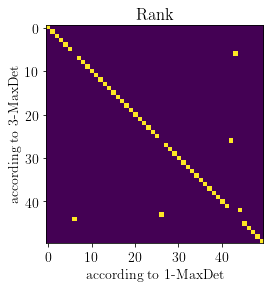

In [10]:
for i in range(len(batch_szs)):
    plt.figure()
    scatter = np.zeros((N, N))
    for j in range(N):
        scatter[S[0][j], S[i][j]] = 1
    plt.imshow(scatter, vmin=0, vmax=1)
    plt.title('Rank')
    plt.xlabel('according to {}-MaxDet'.format(0+1))
    plt.ylabel('according to {}-MaxDet'.format(i+1))
    plt.savefig(f'ccorr-maxdet-{0+1}-{i+1}', dpi=300)

In [11]:
MCtotal = 100
scatter = np.zeros((N, N))
ldmc = np.zeros((N,))
for mc_count in tqdm.tnrange(MCtotal, desc='Monte Carlo:'):
    _, u = gsp.GeometricUWG.make_random_pretty().spectral_decomposition()
    uf = u[:, F]
    s1, ld1 = maxdet(uf, batchsz=1, granular='greedy')
    s2, ld2 = maxdet(uf, batchsz=2, granular='greedy')
    scatter[s1, s2] += 1
    ldmc += (np.asarray(ld1) - np.asarray(ld2))**2

/home/pedro/.local/lib/pyenv/versions/3.7.2/envs/gsp/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log


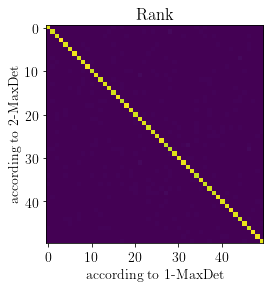

In [12]:
plt.figure()
plt.imshow(scatter / scatter.max(), vmin=0, vmax=1)
plt.title('Rank')
plt.xlabel('according to {}-MaxDet'.format(1))
plt.ylabel('according to {}-MaxDet'.format(2))
plt.savefig('ccorr-mc.png', dpi=300)
plt.figure()
plt.semilogy(np.sqrt(ldmc))
plt.ylim((1e-4, 1e0))
plt.grid()
plt.ylabel('logdet discrepancy')
plt.savefig('ldet-discrepancy-mc.png', dpi=300)

(array([ 4.,  0.,  2.,  0.,  6.,  0.,  7.,  0., 12.,  0.,  0.,  7.,  0.,
         5.,  0.,  6.,  0.,  0.,  0.,  1.]),
 array([ 91.  ,  91.45,  91.9 ,  92.35,  92.8 ,  93.25,  93.7 ,  94.15,
         94.6 ,  95.05,  95.5 ,  95.95,  96.4 ,  96.85,  97.3 ,  97.75,
         98.2 ,  98.65,  99.1 ,  99.55, 100.  ]),
 <a list of 20 Patch objects>)

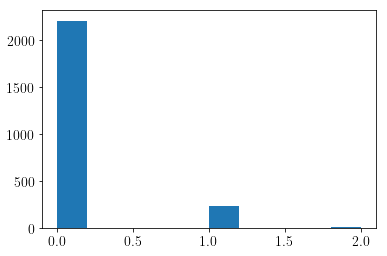

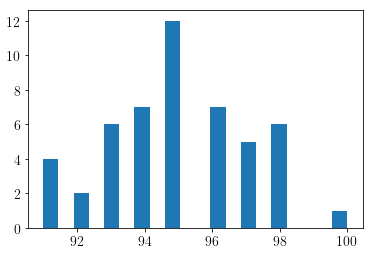

In [17]:
flsc = scatter.flatten()
thresh = flsc.max() / 2

plt.figure()
plt.hist(flsc[flsc < thresh], bins=10)

plt.figure()
plt.hist(flsc[flsc >= thresh], bins=20)

First $\#\Fcal$ nodes of the list:

In [18]:
S = S[0]

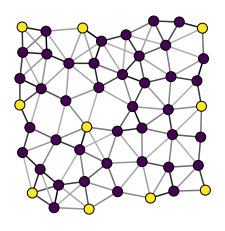

In [14]:
S_mask = np.zeros(N, dtype=bool)
S_mask[S[:M]] = True
gsp.GraphSignal(S_mask.astype(float), graph=graph).plot(
    colorbar=False, filename='sampled-10.png', dpi=300, edge_color='grayscale')

$\xbf_0=\mbox{Random graph signal bandlimited to $\Fcal$}$

In [15]:
F_mask = np.zeros(N, dtype=bool)
F_mask[F] = True

def random_F(*, band=F_mask, graph=graph, 
             random_source=np.random.standard_normal):
    """Generates a random bandlimited graph signal.
    
    band: a vector of booleans specifying the band
    U: a unitary matrix whose columns are eigensignals of the graph
    random_source: a function that receives an integer N and returns N random
        real numbers.
    """
    f = gsp.GraphSignalSpectrum(random_source(len(U)) * band, graph=graph, mutable=False)
    return f.igft

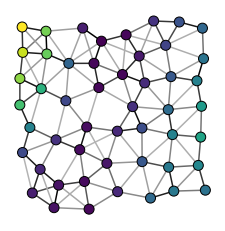

In [16]:
np.random.seed(seed=0)
x0 = random_F(random_source=np.random.standard_normal)
x0.plot(colorbar=False, filename='bandlimited.png', dpi=300, edge_color='grayscale')

In [69]:
T = 400 #500

mu = 0.1
x_hat = []

S_size_list = [7, 8, 9, 10, 20, 30, 50]
grad_norms = []

np.random.seed(seed=11) # 1
v_stdev = np.sqrt(0.01 * np.random.random_sample(N))
for S_size in S_size_list:
    D = np.zeros((N,N))
    D[S[:S_size],S[:S_size]] = 1
    Bf = np.zeros((N,N))
    Bf[F,F] = 1
    B = U @ Bf @ U.T
    mBD = mu * B @ D
    x_hat.append([random_F()])
    grad_norms.append([])
    for t in range(1,T):
        v = np.random.normal(scale=v_stdev)
        mgrad = mBD @ (x0 + v - x_hat[-1][-1])
        x_hat[-1].append(x_hat[-1][-1] + mgrad)
        grad_norms[-1].append(np.linalg.norm(mgrad)/mu)

samples: 10 -> alpha = 0.991566361312355
samples: 20 -> alpha = 0.9412474043677479
samples: 30 -> alpha = 0.9156425357960906
samples: 50 -> alpha = 0.8000000000000127


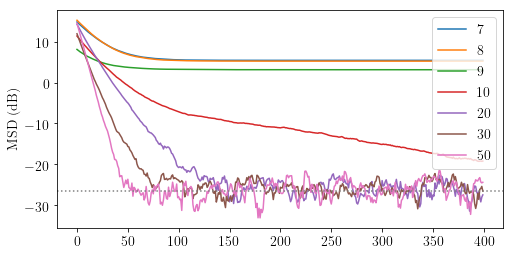

In [70]:
msd = []
for i in range(len(S_size_list)):
    msd.append([])
    for t in range(T):
        msd[-1].append((x_hat[i][t] - x0).norm())
D = np.zeros((N,N))
D[S[:M],S[:M]] = 1
msd_theo = mu/2*np.trace(np.linalg.inv(UF.T@D@UF)@UF.T@D@np.diag(v_stdev**2)@UF)
fig, ax = plt.subplots(figsize=(8,4))
lines = ax.plot(20*np.log10(np.asarray(msd).T))
for i in range(len(lines)):
    D = np.zeros((N,N))
    D[S[:S_size_list[i]],S[:S_size_list[i]]] = 1
    ews, _ = np.linalg.eigh(UF.T@D@UF)
    if ews.min() <= 1e-14:
        continue
    alpha = 1 - 2*mu*ews.min()
    print('samples: {} -> alpha = {}'.format(S_size_list[i], alpha))
    #ax.plot([0, np.log(np.sqrt(msd_theo)/msd[i][0])/np.log(alpha)],
    #         [20*np.log10(msd[i][0]), 10*np.log10(msd_theo)],
    #         linestyle=':', c=lines[i].get_color())
ax.legend([str(Ssz) for Ssz in S_size_list], fontsize=dfs, loc='upper right')
ax.axhline(10*np.log10(msd_theo), linestyle=':', c='gray')
ax.set_ylabel('MSD (dB)', fontsize=dfs)
fig.savefig('lms-eg.png', dpi=300, bbox_inches='tight')

## Probabilistic sampling

Sample according to a vector $\pbf\in\mathbb R^N$ of probabilities. (For each node $i$, $p_i$ is the probability that this node will be chosen for sampling.)

### Formulas

* Matrix of eigenvector contributions to signal values on sampled nodes (EVC matrix):
$$ \Kbf_\pbf = \Ubf_\Fcal^* \mathrm{diag}\prt{\pbf}\Ubf_\Fcal = \sum p_i \ubf_\Fcal^{\prt{i}} \ubf_\Fcal^{\prt{i}*}$$
where $\ubf_\Fcal^{\prt{i}}$ is the transpose of the $i$-th row of $\Ubf_\Fcal$, that is, the vector of values that the eigenvectors of $\Fcal$ assume at the vertex $i$. This matrix is analogous to the 
$\Ubf_\Fcal^* \Dbf\Ubf_\Fcal$ matrix in the static sampling scenario.

* LMS learning rate:
$$ \alpha \approx 1-2\mu\lambda_{\min}\prt{\Kbf_\pbf} $$

* LMS theoretical MSD:
$$ \frac\mu 2 \tr\left\{\Kbf_\pbf^{-1} \Ubf_\Fcal^* \mathrm{diag}\prt{\pbf} \Cbf_\vbf \Ubf_\Fcal \right\} $$

### Minimum sampling rate subj. to fast/accurate learning

Optimization problem: find positive $\pbf$ that minimizes $\boldsymbol{1}^T\pbf$ subject to:

* Learning rate: $\alpha \leqslant \bar\alpha$
* MSD $\leqslant\gamma$
* Energy/resources limitations on individual nodes: $\pbf\leqslant\pbf_\max$

MSD constraint above
$$\tr\left\{\Kbf_\pbf^{-1} \Ubf_\Fcal^* \mathrm{diag}\prt{\pbf} \Cbf_\vbf \Ubf_\Fcal \right\}
\leqslant \frac{2\gamma}\mu$$
is not convex. Relaxation:
$$\frac{\tr\left\{ \Ubf_\Fcal^* \mathrm{diag}\prt{\pbf} \Cbf_\vbf \Ubf_\Fcal \right\}}{\lambda_\min\prt{\Kbf_\pbf}}
\leqslant \frac{2\gamma}\mu$$

In [ ]:
for S_size in S_size_list:
    p = np.zeros((N,))
    p[S[:S_size]] = 1
    D = np.diag(p)
    msd_theo = mu/2*np.trace(np.linalg.inv(UF.T@D@UF)@UF.T@D@np.diag(v_stdev**2)@UF)
    ews, _ = np.linalg.eigh(UF.T@D@UF)
    if ews.min() <= 1e-14:
        continue
    alpha = 1 - 2*mu*ews.min()
    gamma_bar = mu/2 * np.trace(UF.T@D@np.diag(v_stdev**2)@UF) / ews.min()
    print("\n'p = S[:{}]':".format(S_size))
    print('  alpha = {}'.format(alpha))
    print("  MSD bar = ", gamma_bar)
    print('  MSD theo = {}'.format(msd_theo))

In [ ]:
def msr_get_prob(UF, *, mu, v_stdev, alpha_bar, gamma, p_max=None):
    N = len(UF)
    if p_max is None:
        p_max = np.ones((N,))
    p = cvx.Variable((N,), nonneg=True)
    constraints = [
        cvx.lambda_min(UF.T * cvx.diag(p) * UF) >= (1 - alpha_bar) / (2 * mu),
        cvx.trace(UF.T * cvx.diag(p * v_stdev**2) * UF) <= (2 * gamma / mu) * cvx.lambda_min(UF.T * cvx.diag(p) * UF),
        p >= 0,
        p <= p_max,
    ]
    obj = cvx.Minimize(cvx.sum(p))
    prob = cvx.Problem(obj, constraints)
    return prob, p

In [ ]:
%%time
alpha_bar = [.99, .96, .93, .81]
gamma = [.1, .1, .1, .2]

p = []
prob_status = []
prob_value = []
for a, g in zip(alpha_bar, gamma):
    prob, p_ = msr_get_prob(UF, mu=mu, v_stdev=v_stdev, alpha_bar=a, gamma=g)
    prob.solve()
    prob_status.append(prob.status)
    prob_value.append(prob.value)
    p_ = p_.value
    assert p_ is not None, "a={} and g={} is bad".format(a, g)
    p_[p_ < 0] = 0
    p_[p_ > 1] = 1
    p.append(p_)

In [ ]:
def msr_get_alpha(UF, mu, p):
    D = np.diag(p)
    ews, _ = np.linalg.eigh(UF.T@D@UF)
    return 1 - 2*mu*ews.min()

def msr_get_gamma(UF, mu, v_stdev, p):
    D = np.diag(p)
    ews, _ = np.linalg.eigh(UF.T@D@UF)
    return mu/2 * np.trace(UF.T@D@np.diag(v_stdev**2)@UF) / ews.min()

def msr_get_msd(UF, mu, v_stdev, p):
    D = np.diag(p)
    return mu/2 * np.trace(np.linalg.inv(UF.T@D@UF)@UF.T@D@np.diag(v_stdev**2)@UF)
    
for i in range(len(p)):
    print('\n')
    print("status:", prob_status[i])
    print("optimal value", prob_value[i])
    print("alpha: ", msr_get_alpha(UF, mu, p[i]))
    print("gamma bar: ", msr_get_gamma(UF, mu, v_stdev, p[i]))
    print("msd theo:  ", msr_get_msd(UF, mu, v_stdev, p[i]))

In [ ]:
for p_ in p:
    gplot(gsp.GraphSignal(p_, graph=graph))

In [ ]:
df = pd.DataFrame([
    [10,  3, .99, .99, .010, .0016, .0014],
    [20, 10, .96, .96, .007, .0016, .0014],
    [30, 18, .93, .93, .004, .0023, .0021],
    [50, 48, .81, .81, .003, .0014, .0024],
], columns=['M exp', 'M att', 'alpha exp', 'alpha att', 'gamma exp', 'gamma_att', 'msd att'])
df

# Recursive least squares

At time $n$, find the signal with spectrum representation $\hat\sbf\brak{n}$ by solving:
$$\min_\sbf \sum_{l=1}^n 
\beta^{n-l}\left\|\Dbf_{\Scal\brak{l}}\prt{\ybf\brak{l}-\Ubf_\Fcal\sbf}\right\|_{\Cbf_\vbf^{-1}}^2 + \beta^n
\left\|\sbf\right\|_\Pibf^2$$

Algorithm: repeat
* $\Psibf\brak{n} = \beta \Psibf\brak{n-1} + \Ubf_\Fcal^*\Dbf_{\Scal\brak{n}}
   \Cbf_\vbf^{-1} \Ubf_\Fcal$
* $\psibf\brak{n} = \beta \psibf\brak{n-1} + \Ubf_\Fcal^*\Dbf_{\Scal\brak{n}}
   \Cbf_\vbf^{-1} \ybf\brak{n}$
* $\hat\xbf = \Ubf_\Fcal\Psibf\brak{n}^{-1}\psi\brak{n}$

## Probabilistic sampling

* Theoretical MSD = $\lim_{n\to\infty} \expval{\hat\xbf\brak{n}-\xbf^o}$ =
$$\frac{1-\beta}{1+\beta}\tr\left\{\prt{ \Ubf_\Fcal^* \mathrm{diag}\prt{\pbf} \Cbf_\vbf^{-1} \Ubf_\Fcal }^{-1}\right\}$$

Optimization problem: choose positive $\pbf$ minimizing $\boldsymbol{1}^T\pbf$ subject to:
* MSD $\leqslant\gamma$
* $\pbf\leqslant\pbf_\max$

# Simulations

## Random $\xbf_0$

In [ ]:
x0 = random_F()
gplot(x0)

## Parameters

In [ ]:
mu = 0.1

S_size_list = [7, 8, 9, 10, 20, 30, 50]
T = 400
MCtotal = 100

## Monte Carlo for LMS with (static) Max-Det sampling

In [ ]:
x_hat = np.empty((MCtotal, len(S_size_list), N, T+1))
grad_norms = np.empty((MCtotal, len(S_size_list), T))
for mc_count in tqdm.tnrange(MCtotal, desc='Monte Carlo:'):
    v_stdev = np.sqrt(0.01 * np.random.random_sample(N))
    for Ssz_count in range(len(S_size_list)):
        D = np.zeros((N,N))
        sample_indices = S[:S_size_list[Ssz_count]]
        D[sample_indices, sample_indices] = 1
        Bf = np.zeros((N,N))
        Bf[F,F] = 1
        B = U @ Bf @ U.T
        mBD = mu * B @ D
        x_hat[mc_count, Ssz_count, :, 0] = random_F().values
        for t in range(T):
            v = np.random.normal(scale=v_stdev)
            mgrad = mBD @ (x0 + v - x_hat[mc_count, Ssz_count, :, t])
            x_hat[mc_count, Ssz_count, :, t+1] = x_hat[mc_count, Ssz_count, :, t] + mgrad
            grad_norms[mc_count, Ssz_count, t] = np.linalg.norm(mgrad) / mu

In [ ]:
msd = np.empty((MCtotal, len(S_size_list), T+1))
for mc_count in tqdm.tnrange(MCtotal, desc='MC means:'):
    for Ssz_count in range(len(S_size_list)):
        for t in range(T+1):
            msd[mc_count, Ssz_count, t] = np.linalg.norm(x_hat[mc_count, Ssz_count, :, t] - x0)
msd_mean = msd.mean(axis=0)
msd_std = msd.std(axis=0)

In [ ]:
plt.figure(figsize=(8,6))
lines = []
for i in range(len(S_size_list)):
    xpts = np.arange(T+1)
    ypts = msd_mean[i, :]
    yerr = msd_std[i, :]/3
    hop = 4
    lines.append(plt.errorbar(xpts[::hop], ypts[::hop], yerr=yerr[::hop]))

D = np.zeros((N,N))
D[S[:M], S[:M]] = 1
msd_theo = np.sqrt(mu/2*np.trace(np.linalg.inv(UF.T@D@UF)@UF.T@D@(0.005*np.eye(N))@UF))

plt.yscale('log')
plt.legend([str(Ssz) for Ssz in S_size_list], fontsize=dfs)
for i in range(len(S_size_list)):
    D = np.zeros((N,N))
    D[S[:S_size_list[i]],S[:S_size_list[i]]] = 1
    ews, _ = np.linalg.eigh(UF.T@D@UF)
    if ews.min() <= 0:
        continue
    alpha = 1 - 2*mu*ews.min()
    print('samples: {} -> alpha = {}'.format(S_size_list[i], alpha))
    plt.plot([0, np.log(msd_theo/msd_mean[i][0])/np.log(alpha)],
             [msd_mean[i][0], msd_theo],
             linestyle=':', c=lines[i].get_children()[0].get_color())
plt.axhline(msd_theo, linestyle=':', c='gray')
plt.ylabel('MSD', fontsize=dfs)

## Monte Carlo for LMS with random sampling

In [ ]:
x_hat = np.empty((MCtotal, len(S_size_list), N, T+1))
grad_norms = np.empty((MCtotal, len(S_size_list), T))
for mc_count in tqdm.tnrange(MCtotal, desc='Monte Carlo:'):
    v_stdev = np.sqrt(0.01 * np.random.random_sample(N))
    S_rand = np.random.permutation(50)
    for Ssz_count in range(len(S_size_list)):
        D = np.zeros((N,N))
        sample_indices = S_rand[:S_size_list[Ssz_count]]
        D[sample_indices, sample_indices] = 1
        Bf = np.zeros((N,N))
        Bf[F,F] = 1
        B = U @ Bf @ U.T
        mBD = mu * B @ D
        x_hat[mc_count, Ssz_count, :, 0] = random_F().values
        for t in range(T):
            v = np.random.normal(scale=v_stdev)
            mgrad = mBD @ (x0 + v - x_hat[mc_count, Ssz_count, :, t])
            x_hat[mc_count, Ssz_count, :, t+1] = x_hat[mc_count, Ssz_count, :, t] + mgrad
            grad_norms[mc_count, Ssz_count, t] = np.linalg.norm(mgrad) / mu

In [ ]:
msd = np.empty((MCtotal, len(S_size_list), T+1))
for mc_count in tqdm.tnrange(MCtotal, desc='MC means:'):
    for Ssz_count in range(len(S_size_list)):
        for t in range(T+1):
            msd[mc_count, Ssz_count, t] = np.linalg.norm(x_hat[mc_count, Ssz_count, :, t] - x0)
msd_rand_mean = msd.mean(axis=0)
msd_rand_std = msd.std(axis=0)

In [ ]:
plt.figure(figsize=(8,6))
for i in range(len(S_size_list)):
    xpts = np.arange(T+1)
    ypts = msd_rand_mean[i, :]
    yerr = msd_rand_std[i, :]/3
    hop = 4
    plt.errorbar(xpts[::hop], ypts[::hop], yerr=yerr[::hop])
D = np.zeros((N,N))
D[S[:M], S[:M]] = 1
msd_theo = np.sqrt(mu/2*np.trace(np.linalg.inv(UF.T@D@UF)@UF.T@D@(0.005*np.eye(N))@UF))
plt.legend([str(Ssz) for Ssz in S_size_list], fontsize=dfs, loc='upper right')
plt.axhline(msd_theo, linestyle=':', c='gray')
plt.yscale('log')
plt.ylabel('MSD', fontsize=dfs)

## Monte Carlo for LMS with probabilistic sampling

In [ ]:
x_hat = np.empty((MCtotal, len(p), N, T+1))
grad_norms = np.empty((MCtotal, len(p), T))
num_samples = np.empty((MCtotal, len(p), T))
for mc_count in tqdm.tnrange(MCtotal, desc='Monte Carlo:'):
    v_stdev = np.sqrt(0.01 * np.random.random_sample(N))
    for i in range(len(p)):
        Bf = np.zeros((N,N))
        Bf[F,F] = 1
        B = U @ Bf @ U.T
        mB = mu * B
        x_hat[mc_count, i, :, 0] = random_F().values
        for t in range(T):
            curr_sel = np.array(np.random.random_sample((N,)) < p[i], dtype=float)
            num_samples[mc_count, i, t] = curr_sel.sum()
            D = np.diag(curr_sel)
            mBD = mB @ D
            v = np.random.normal(scale=v_stdev)
            mgrad = mBD @ (x0 + v - x_hat[mc_count, i, :, t])
            x_hat[mc_count, i, :, t+1] = x_hat[mc_count, i, :, t] + mgrad
            grad_norms[mc_count, i, t] = np.linalg.norm(mgrad) / mu

In [ ]:
msd = np.empty((MCtotal, len(p), T+1))
for mc_count in tqdm.tnrange(MCtotal, desc='MC means:'):
    for i in range(len(p)):
        for t in range(T+1):
            msd[mc_count, i, t] = np.linalg.norm(x_hat[mc_count, i, :, t] - x0)
msd_prand_mean = msd.mean(axis=0)
msd_prand_std = msd.std(axis=0)

In [ ]:
plt.figure(figsize=(8,6))
for i in range(len(p)):
    xpts = np.arange(T+1)
    ypts = msd_prand_mean[i, :]
    yerr = msd_prand_std[i, :]/3
    hop = 4
    plt.errorbar(xpts[::hop], ypts[::hop], yerr=yerr[::hop])
D = np.zeros((N,N))
D[S[:M], S[:M]] = 1
msd_theo = np.sqrt(mu/2*np.trace(np.linalg.inv(UF.T@D@UF)@UF.T@D@(0.005*np.eye(N))@UF))
plt.legend([str(optval) for optval in df['M att']], fontsize=dfs, loc='upper right')
plt.axhline(msd_theo, linestyle=':', c='gray')
plt.yscale('log')
plt.ylabel('MSD', fontsize=dfs)

## RLS, Monte Carlo, with (static) Max-Det sampling

In [ ]:
delta = 0.1 # regularization for RLS
beta = 0.95

In [ ]:
S_size_list = [10, 20, 30, 50]
x_hat = np.empty((MCtotal, len(S_size_list), N, T+1))
for mc_count in tqdm.tnrange(MCtotal, desc='Monte Carlo:'):
    v_stdev = np.sqrt(0.01 * np.random.random_sample(N))
    Cv = np.diag(v_stdev)
    Cv_inv = np.diag(1/v_stdev)
    for Ssz_count in range(len(S_size_list)):
        D = np.zeros((N,N))
        sample_indices = S[:S_size_list[Ssz_count]]
        D[sample_indices, sample_indices] = 1
        UDC = UF.T @ D @ Cv_inv
        Psi = UDC @ UF / (1-beta)
        Psi_inv = np.linalg.inv(Psi)
        UPi = UF @ Psi_inv
        psi = random_F().gft.values[F]
        x_hat[mc_count, Ssz_count, :, 0] = UPi @ psi
        for t in range(T):
            v = v_stdev * np.random.random_sample(N)
            psi = beta * psi + UDC @ (x0 + v)
            x_hat[mc_count, Ssz_count, :, t+1] = UPi @ psi

In [ ]:
msd = np.empty((MCtotal, len(S_size_list), T+1))
for mc_count in tqdm.tnrange(MCtotal, desc='MC means:'):
    for Ssz_count in range(len(S_size_list)):
        for t in range(T+1):
            msd[mc_count, Ssz_count, t] = np.linalg.norm(x_hat[mc_count, Ssz_count, :, t] - x0)
msd_rand_mean = msd.mean(axis=0)
msd_rand_std = msd.std(axis=0)
for i in range(len(S_size_list)):
    plt.errorbar(range(T+1), msd_rand_mean[i, :], yerr=msd_rand_std[i, :]/3)
plt.yscale('log')
plt.legend([str(Ssz) for Ssz in S_size_list], fontsize=dfs, loc='upper right')
plt.ylabel('MSD', fontsize=dfs)

## RLS, Random sampling

In [ ]:
S_size_list = [10, 20, 30, 50]
x_hat = np.empty((MCtotal, len(S_size_list), N, T+1))
for mc_count in tqdm.tnrange(MCtotal, desc='Monte Carlo:'):
    v_stdev = np.sqrt(0.01 * np.random.random_sample(N))
    Cv = np.diag(v_stdev)
    Cv_inv = np.diag(1/v_stdev)
    S_rand = np.random.permutation(50)
    for Ssz_count in range(len(S_size_list)):
        D = np.zeros((N,N))
        sample_indices = S_rand[:S_size_list[Ssz_count]]
        D[sample_indices, sample_indices] = 1
        UDC = UF.T @ D @ Cv_inv
        Psi = UDC @ UF / (1-beta)
        Psi_inv = np.linalg.inv(Psi)
        UPi = UF @ Psi_inv
        psi = random_F().gft.values[F]
        x_hat[mc_count, Ssz_count, :, 0] = UPi @ psi
        for t in range(T):
            v = v_stdev * np.random.random_sample(N)
            psi = beta * psi + UDC @ (x0 + v)
            x_hat[mc_count, Ssz_count, :, t+1] = UPi @ psi

In [ ]:
msd = np.empty((MCtotal, len(S_size_list), T+1))
for mc_count in tqdm.tnrange(MCtotal, desc='MC means:'):
    for Ssz_count in range(len(S_size_list)):
        for t in range(T+1):
            msd[mc_count, Ssz_count, t] = np.linalg.norm(x_hat[mc_count, Ssz_count, :, t] - x0)
msd_rand_mean = msd.mean(axis=0)
msd_rand_std = msd.std(axis=0)
for i in range(len(S_size_list)):
    plt.errorbar(range(T+1), msd_rand_mean[i, :], yerr=msd_rand_std[i, :]/3)
plt.yscale('log')
plt.legend([str(Ssz) for Ssz in S_size_list], fontsize=dfs, loc='upper right')
plt.ylabel('MSD', fontsize=dfs)

In [ ]:
for i in range(1,len(S_size_list)):
    plt.errorbar(range(T+1), msd_rand_mean[i, :], yerr=msd_rand_std[i, :]/3)
plt.yscale('log')
plt.legend([str(Ssz) for Ssz in S_size_list[1:]], fontsize=dfs, loc='upper right')
plt.ylabel('MSD', fontsize=dfs)